# Deep Learning Course: Lab Exercises

In this lab exercise you will:

Learn about RNN and LSTM on toy sequential tasks:

Part 1: RNN and LSTM based 1D signal classifier & predictor

Part 2: RNN and LSTM based names classification with a character-level model

In [1]:
### Connect to Google Drive if you are using Drive.
from google.colab import drive

drive = drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# working folder
import os
working_dir = 'drive/MyDrive/FDL_lab_6'
os.chdir(working_dir)

In [3]:
### Import all your libraries
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as data

import numpy as np
from scipy import signal

from sklearn.metrics import f1_score

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
# CPU or GPU device ?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cpu


## Part 1: RNN and LSTM based 1D signal classifier & predictor

### 1.A. Data

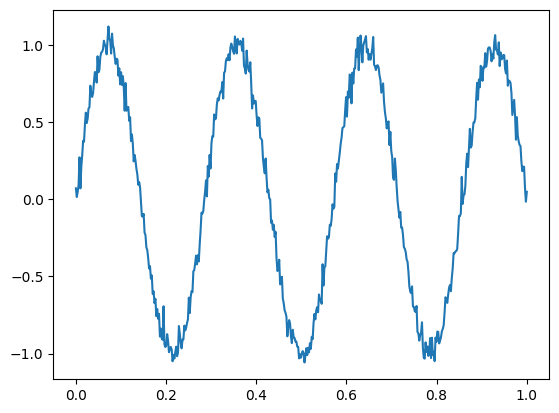

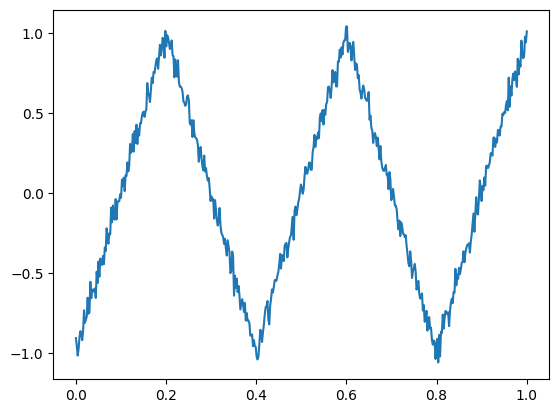

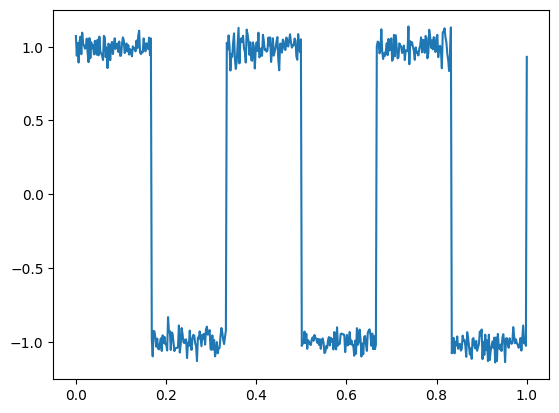

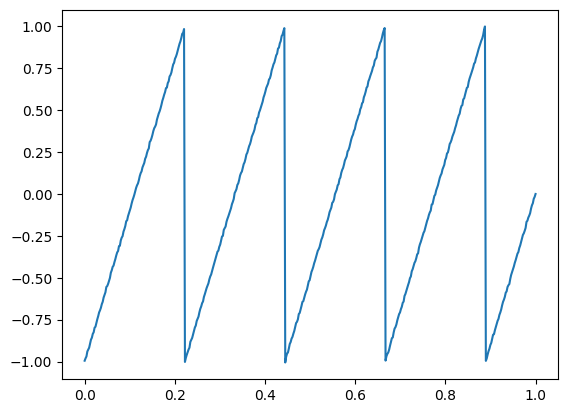

In [5]:
## Sine, Sawtooth, Tirangloe and Square wave generators
# *****START CODE
def get_noise():
    std = random.uniform(0, 0.1)
    noise = np.random.normal(0, std, 500)
    return noise

def get_sine():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    sine = np.sin(repeats * np.pi * time) + noise
    return time, sine

def get_triangle():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    triangle = signal.sawtooth(repeats * np.pi * time, 0.5) + noise
    return time, triangle

def get_square():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    square = signal.square(repeats * np.pi * time, 0.5) + noise
    return time, square

def get_sawtooth():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    sawtooth = signal.sawtooth(repeats * np.pi * time) + noise
    return time, sawtooth

plt.plot(*get_sine())
plt.show()

plt.plot(*get_triangle())
plt.show()

plt.plot(*get_square())
plt.show()

plt.plot(*get_sawtooth())
plt.show()
# *****END CODE

### 1.B. RNN Wave Classification

In [6]:
## Dataloader

class WavePreloader(data.Dataset):

    def __init__(self, samples=1000):
        self.samples = samples # Total samples to be generated in the dataset
        self.funcs = [get_sine, get_triangle, get_sawtooth, get_square] # functions to generate a sample

    def __getitem__(self, index):
        cls_lbl = random.randint(0, 3) # randomly get a function to generate
        _, inp = self.funcs[cls_lbl]() # generate wave

        return inp.reshape(-1, 1), cls_lbl # return generated wave and corresponding class label

    def __len__(self):
        return self.samples


In [7]:
## RNN classifier

# *****START CODE
class WaveClassifier(nn.Module):
    def __init__(self, n_classes=4, hidden_size=8, device='cpu'):
        super(WaveClassifier, self).__init__()
        self.n_classes = n_classes
        self.hidden_size = hidden_size
        self.device = device

        self.rnn = nn.RNN(input_size=1,
                          hidden_size=self.hidden_size,
                          num_layers=1,
                          nonlinearity='relu',
                          batch_first=True)
        # Define a 1 layer RNN which gives 8 dimensional feature map ouput
        self.linear = nn.Linear(self.hidden_size, self.n_classes)
        # Define a linear layer that takes a vector of size 8 as input and gives num classes as ouput

    def forward(self, x):
        h0 = torch.randn(1, x.size(0), self.hidden_size, device=self.device).float()
        x, hn = self.rnn(x, h0)
         # create h0 tensor which has same size as input x
        x = self.linear(x[:, -1, :])
         # forward pass through rnn
         # apply linear layer to last time step of rnn output
        return x
# *****END CODE

In [8]:
## Instantiate dataloader, optimizer, loss, and network
n_classes = 4
hidden_size = 8
lr = 0.01
batch_size = 256
epochs = 10

# *****START CODE
# define training dataset
train_dataset = WavePreloader(samples=5000)
test_dataset = WavePreloader(samples=5000)
# define test dataset

# define train loader
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# define test loader

# define a multi class loss
criterion = nn.CrossEntropyLoss()
# instantiate your network (on the device)
model = WaveClassifier(n_classes=n_classes, hidden_size=hidden_size, device=device).to(device)
# instantiate your optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# *****END CODE


In [9]:
## Train your network

# *****START CODE
for epoch in range(epochs):
    running_train_loss = []   # variable to accumulate losses
    running_test_loss = []

    train_predictions = []    # variable to accumulate predictions and ground truth labels
    train_ground_truths = []

    test_predictions = []
    test_ground_truths = []

    # train loop

    model.train()
    for inp_batch, lbl_batch in train_loader:
        model.zero_grad()

        inp_batch = inp_batch.float().to(device)
        lbl_batch = lbl_batch.to(device)

        pred = model(inp_batch)

        loss = criterion(pred, lbl_batch)
        loss.backward()
        optimizer.step()

        pred = torch.argmax(pred, dim=-1)

        running_train_loss.append(loss.item())

        train_predictions += list(pred.cpu().data.numpy())
        train_ground_truths += list(lbl_batch.cpu().data.numpy())


    # test loop
    model.eval()
    for inp_batch, lbl_batch in test_loader:

        inp_batch = inp_batch.float().to(device)
        lbl_batch = lbl_batch.to(device)
        with torch.no_grad():
            pred = model(inp_batch)

        loss = criterion(pred, lbl_batch)

        pred = torch.argmax(pred, dim=-1)

        running_test_loss.append(loss.item())

        test_predictions += list(pred.cpu().data.numpy())
        test_ground_truths += list(lbl_batch.cpu().data.numpy())

    # print mean epoch loss and f1 score using accumulated loss and accumulated labels
    print (f"\n###### Epoch {epoch} ######")
    print ("Train Loss : ", np.mean(running_train_loss))
    print ("Train F1 Score : ", f1_score(train_ground_truths, train_predictions, average="macro"))

    print ("Test Loss : ", np.mean(running_test_loss))
    print ("Test F1 Score : ", f1_score(test_ground_truths, test_predictions, average="macro"))
# *****END CODE


###### Epoch 0 ######
Train Loss :  1.2919354081153869
Train F1 Score :  0.34076575035524476
Test Loss :  1.13164279460907
Test F1 Score :  0.4652701529612123

###### Epoch 1 ######
Train Loss :  0.9097014933824539
Train F1 Score :  0.4900662806300231
Test Loss :  0.731908056139946
Test F1 Score :  0.47455371318820105

###### Epoch 2 ######
Train Loss :  0.6339883089065552
Train F1 Score :  0.6258990708735495
Test Loss :  0.5060561791062355
Test F1 Score :  0.824320514909622

###### Epoch 3 ######
Train Loss :  0.5919548332691192
Train F1 Score :  0.7013814773145693
Test Loss :  0.5675963670015335
Test F1 Score :  0.7155394891886715

###### Epoch 4 ######
Train Loss :  0.5401663139462471
Train F1 Score :  0.7114344849644807
Test Loss :  0.5121190845966339
Test F1 Score :  0.6791888493029028

###### Epoch 5 ######
Train Loss :  0.49656941592693327
Train F1 Score :  0.6852284770366663
Test Loss :  0.4763689786195755
Test F1 Score :  0.7086185113042851

###### Epoch 6 ######
Train Loss :

### 1.C. LSTM Wave prediction


In [10]:
## Dataloader

class WavePredPreloader(data.Dataset):

    def __init__(self, samples=1000):
        self.samples = samples # Total samples to be generated in the dataset
        self.funcs = [get_sine, get_triangle, get_sawtooth, get_square] # functions to generate a sample

    def __getitem__(self, index):
        cls_lbl = random.randint(0, 3) # randomly get a function to generate
        _, inp = self.funcs[cls_lbl]() # generate wave
        first_half = inp[:250]
        second_half = inp[250:]
        return first_half.reshape(-1, 1), second_half.reshape(-1, 1) # return generated wave split in half as input and label

    def __len__(self):
        return self.samples

In [11]:
## LSTM regressor

# *****START CODE
class WavePredictor(nn.Module):
    def __init__(self, hidden_size=8, num_layers=2, device='cpu'):
        super(WavePredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        # Define a 1 layer LSTM which gives 8 dimensional feature map ouput
        self.lstm_in = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_size,
                               num_layers=self.num_layers,
                               batch_first=True)
        # Define a 1 layer LSTM which gives 8 dimensional input and 1 dimentionsnal ouput
        self.lstm_out = nn.LSTM(input_size=self.hidden_size,
                                hidden_size=1,
                                num_layers=self.num_layers,
                                batch_first=True)

    def forward(self, x):
        # create h0 tensor which has same size as input x
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=self.device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=self.device)
        # create c0 tensor which has same size as input x
        x, (hn, cn) = self.lstm_in(x, (h0, c0))

        # create h0 tensor which has same size as input x
        h0 = torch.randn(self.num_layers, x.size(0), 1, device=self.device)
        c0 = torch.randn(self.num_layers, x.size(0), 1, device=self.device)
        # create c0 tensor which has same size as input x
        x, (hn, cn) = self.lstm_out(x, (h0, c0))
        x = F.tanh(x)
        return x
# *****END CODE

In [12]:
## Instantiate dataloader, optimizer, loss, and network
hidden_size = 64
lr = 0.001
batch_size = 256
epochs = 70

# *****START CODE
train_dataset = WavePredPreloader(samples=10000)
test_dataset = WavePredPreloader(samples=300)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
model = WavePredictor(hidden_size=hidden_size, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# *****END CODE

In [13]:
## Train your network

# *****START CODE
for epoch in range(epochs):
    running_train_loss = []   # variable to accumulate losses
    running_test_loss = []

    # train loop

    model.train()
    for inp_batch, lbl_batch in train_loader:
        model.zero_grad()

        inp_batch = inp_batch.float().to(device)
        lbl_batch = lbl_batch.float().to(device)

        pred = model(inp_batch)

        loss = criterion(pred, lbl_batch)
        loss.backward()
        optimizer.step()

        running_train_loss.append(loss.item())

    # test loop
    model.eval()
    for inp_batch, lbl_batch in test_loader:
        inp_batch = inp_batch.float().to(device)
        lbl_batch = lbl_batch.float().to(device)

        with torch.no_grad():
            pred = model(inp_batch)

        loss = criterion(pred, lbl_batch)

        running_test_loss.append(loss.item())

    # print mean epoch loss and f1 score using accumulated loss and accumulated labels
    print (f"\n###### Epoch {epoch} ######")
    print ("Train Loss : ", np.mean(running_train_loss))

    print ("Test Loss : ", np.mean(running_test_loss))
# *****END CODE


###### Epoch 0 ######
Train Loss :  0.5484544798731804
Test Loss :  0.49308623373508453

###### Epoch 1 ######
Train Loss :  0.5379054911434651
Test Loss :  0.5202296078205109

###### Epoch 2 ######
Train Loss :  0.5290500901639461
Test Loss :  0.5311572849750519

###### Epoch 3 ######
Train Loss :  0.5205215580761433
Test Loss :  0.5449371337890625

###### Epoch 4 ######
Train Loss :  0.5250968493521213
Test Loss :  0.542691707611084

###### Epoch 5 ######
Train Loss :  0.5164653040468693
Test Loss :  0.5096768438816071

###### Epoch 6 ######
Train Loss :  0.5186859220266342
Test Loss :  0.5078487694263458

###### Epoch 7 ######
Train Loss :  0.517833872884512
Test Loss :  0.5271751880645752

###### Epoch 8 ######
Train Loss :  0.5151750698685647
Test Loss :  0.5080199539661407

###### Epoch 9 ######
Train Loss :  0.5155235648155212
Test Loss :  0.45977796614170074

###### Epoch 10 ######
Train Loss :  0.5132142618298531
Test Loss :  0.48140427470207214

###### Epoch 11 ######
Train 

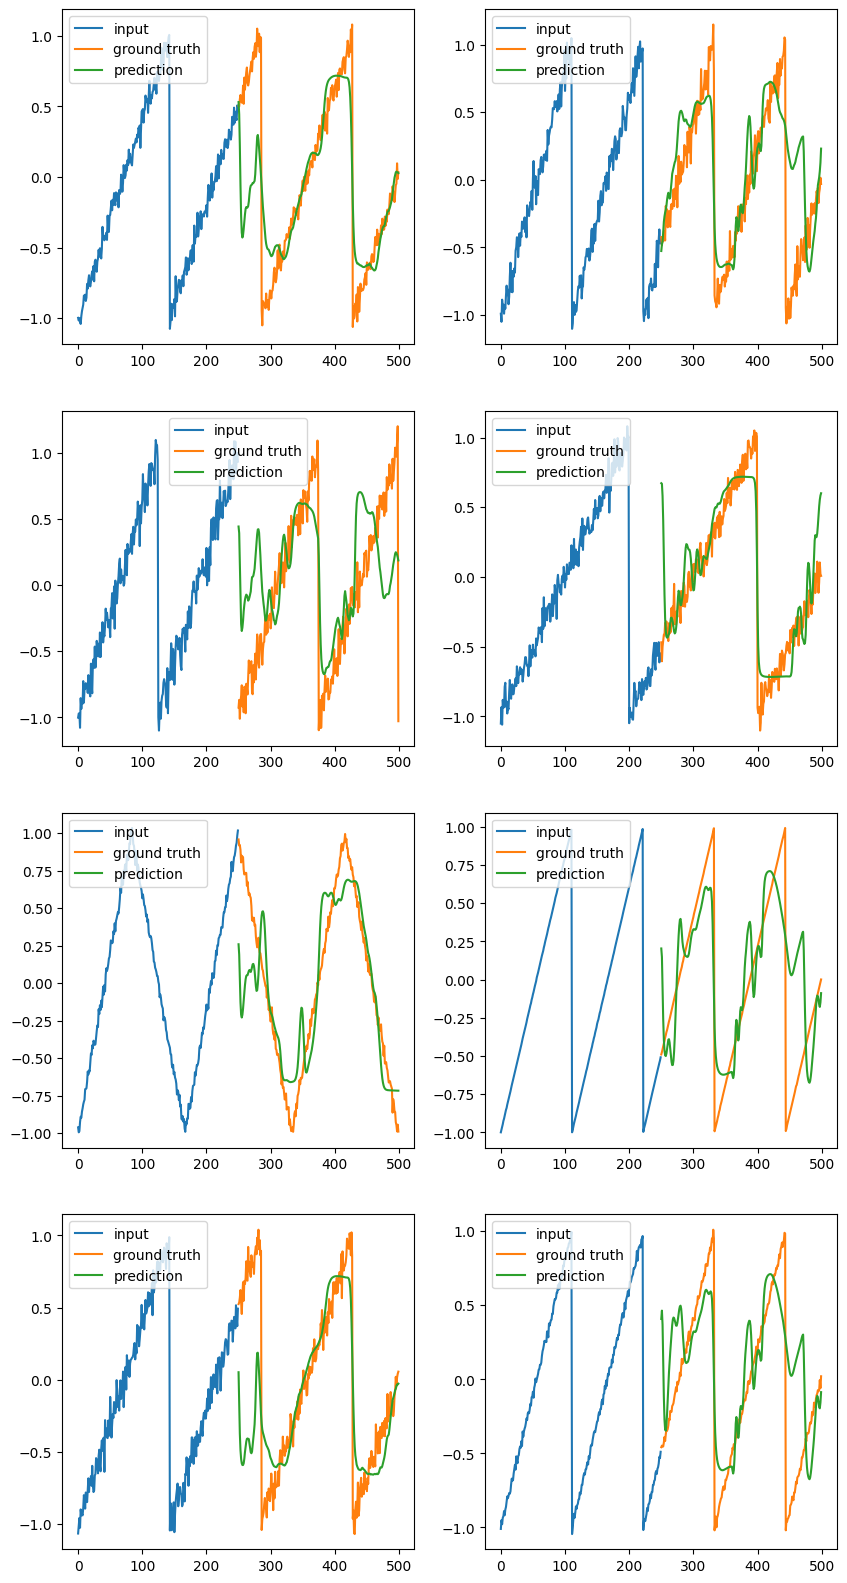

In [14]:
# Plot some evaluation examples

model.eval()
with torch.no_grad():
    inp_batch, lbl_batch = next(iter(test_loader))
    inp_batch = inp_batch.float().to(device)
    lbl_batch = lbl_batch.float().to(device)
    pred = model(inp_batch)

examples_to_show = 8
fig, axs = plt.subplots(examples_to_show//2, 2, figsize=(10,20))
for i in range(examples_to_show):
    axs[i//2, i%2].plot(np.arange(0,250,1), inp_batch.detach().cpu().numpy()[i])
    axs[i//2, i%2].plot(np.arange(250,500,1), lbl_batch.detach().cpu().numpy()[i])
    axs[i//2, i%2].plot(np.arange(250,500,1), pred.detach().cpu().numpy()[i])
    axs[i//2, i%2].legend(['input', 'ground truth', 'prediction'])

## Part 2: RNN and LSTM based names classification with a character-level model

### 2.A. Data

In [15]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/English.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Polish.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt']
Slusarski


In [16]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [17]:
names_data = []
max_length = 0
for category in category_lines.keys():
    lengths = [len(x) for x in category_lines[category]]
    if np.max(lengths)> max_length:
        max_length = np.max(lengths)
    names_data += [[x, category] for x in category_lines[category]]

In [18]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line, max_length=100):
    tensor = torch.zeros(max_length, n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([100, 57])


In [19]:
class NamesDataset(data.Dataset):
    def __init__(self, names_data, max_length=100):
        self.data = names_data
        self.max_length = max_length

    def __getitem__(self, index):
        line, category = self.data[index]
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line, max_length = self.max_length)
        return category, line, category_tensor, line_tensor

    def __len__(self):
        return len(self.data)

### 2.B. Name Classification

In [20]:
# Define a RNN or LSTM model of your choice for names classification

# *****START CODE
class NameClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, device='cpu'):
        super(NameClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.device = device
        self.lstm_in = nn.LSTM(input_size=self.input_size,
                               hidden_size=self.hidden_size,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.lstm_out = nn.LSTM(input_size=self.hidden_size,
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=self.device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=self.device)
        x, (hn, cn) = self.lstm_in(x, (h0, c0))

        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=self.device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=self.device)
        x, (hn, cn) = self.lstm_out(x, (h0, c0))

        x = self.linear(x[:,-1,:])
        return x
# *****END CODE

In [21]:
## Instantiate dataloader, optimizer, loss, and network

n_hidden = 32
lr = 0.01
batch_size = 256
epochs = 50

# *****START CODE
random.shuffle(names_data)
train_dataset = NamesDataset(names_data[:-1000], max_length=max_length)   # define training dataset
test_dataset = NamesDataset(names_data[-1000:], max_length=max_length)    # define test dataset

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)   # define train loader
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)     # define test loader

model = NameClassifier(n_letters, n_hidden, n_categories, device=device).to(device)          # instantiate your network
optimizer = optim.Adam(model.parameters(), lr=lr)   # instantiate your optimizer
criterion = nn.CrossEntropyLoss()
# *****END CODE


In [22]:
!pip install torchnet
import torchnet as tnt

# define confusion matrix using tnt package
confusion_matrix = tnt.meter.ConfusionMeter(n_categories)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29728 sha256=fe3015b42ca3a72ddf2ac55cba90045c907c7f044a5f6383a46f66323b93381d
  Stored in directory: /root/.cache/pip/wheels/f7/ae/94/9f5edd6871983f30967ad11d60ef434c3d1b007654de4c8065
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=3fdc6392a6f3a4833c3c88ba9d98d739324c1e10f0c8c7f7054795ee2803560f
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built torchnet visdom


In [23]:
## Train your network

# *****START CODE
train_loss = []
test_loss = []
for epoch in range(epochs):
    running_train_loss = []   # variable to accumulate losses
    running_test_loss = []


    # train loop
    model.train()
    for batch in train_loader:
        category, line, category_tensor, line_tensor = batch

        model.zero_grad()
        pred = model(line_tensor.to(device))
        loss = criterion(pred.cpu(), torch.squeeze(category_tensor))
        loss.backward()
        optimizer.step()

        running_train_loss.append(loss.item())

    # test loop
    confusion_matrix.reset()
    model.eval()
    for batch in test_loader:
        category, line, category_tensor, line_tensor = batch

        pred = model(line_tensor.to(device))
        loss = criterion(pred.cpu(), torch.squeeze(category_tensor))

        confusion_matrix.add(pred.data.squeeze(), torch.squeeze(category_tensor))
        running_test_loss.append(loss.item())

    # print mean epoch loss and f1 score using accumulated loss and accumulated labels
    print (f"\n###### Epoch {epoch} ######")
    train_loss.append(np.mean(running_train_loss))
    print ("Train Loss : ", np.mean(running_train_loss))
    test_loss.append(np.mean(running_test_loss))
    print ("Val Loss : ", np.mean(running_test_loss))
    #print("Confusion Matrix:")
    #print(confusion_matrix.conf)
    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    print ("Val Acc : ", val_acc)
# *****END CODE


###### Epoch 0 ######
Train Loss :  1.9273373079299927
Val Loss :  1.8064942359924316
Val Acc :  47.099999999999994

###### Epoch 1 ######
Train Loss :  1.8511806551615397
Val Loss :  1.806409329175949
Val Acc :  47.099999999999994

###### Epoch 2 ######
Train Loss :  1.850530482927958
Val Loss :  1.8065827190876007
Val Acc :  47.099999999999994

###### Epoch 3 ######
Train Loss :  1.8503541978200277
Val Loss :  1.8066779971122742
Val Acc :  47.099999999999994

###### Epoch 4 ######
Train Loss :  1.8502771917978922
Val Loss :  1.8068080842494965
Val Acc :  47.099999999999994

###### Epoch 5 ######
Train Loss :  1.850085031191508
Val Loss :  1.8068305552005768
Val Acc :  47.099999999999994

###### Epoch 6 ######
Train Loss :  1.849836630821228
Val Loss :  1.8067719042301178
Val Acc :  47.099999999999994

###### Epoch 7 ######
Train Loss :  1.8496392027537027
Val Loss :  1.8067392408847809
Val Acc :  47.099999999999994

###### Epoch 8 ######
Train Loss :  1.849512095451355
Val Loss :  1

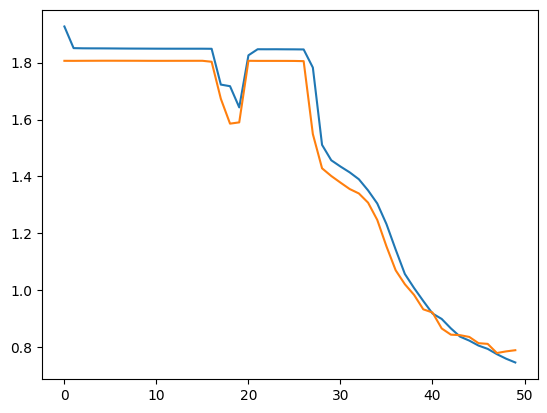

In [24]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)

<ipython-input-25-8323d806f126>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-25-8323d806f126>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


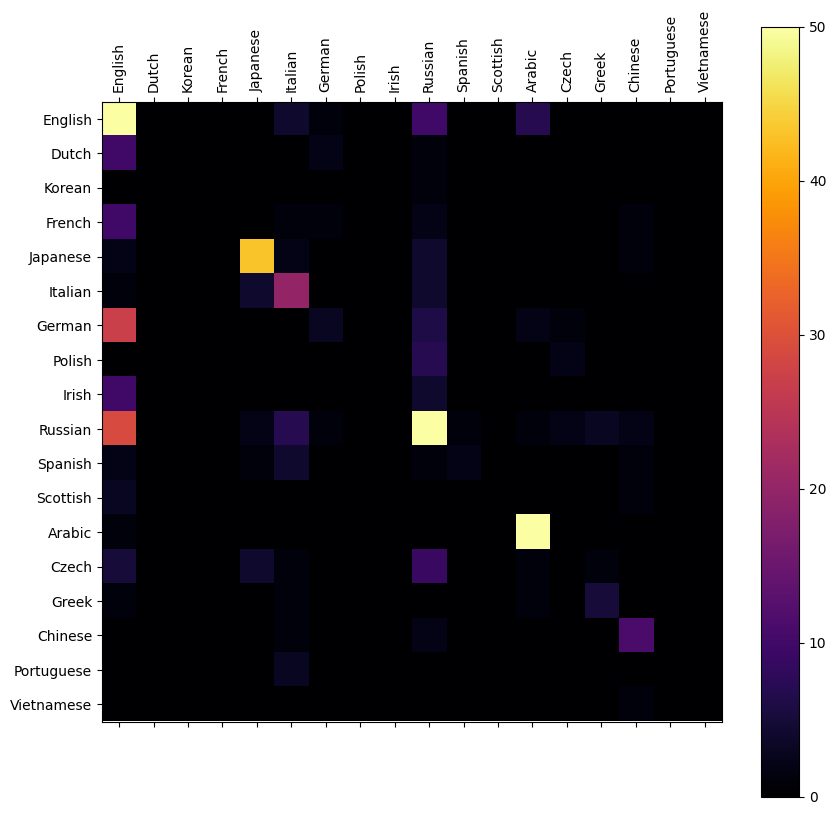

In [25]:
confusion = confusion_matrix.conf

# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap=plt.get_cmap('inferno'), vmax=50)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()